# HW 11 Construct your own simple architecture and train it on your dataset
------
USE: https://pytorch.org/vision/main/generated/torchvision.datasets.ImageFolder.html
## Для выполнения задания необходимо выполнить ряд импортов, включая предопределенные "magic functions" ##


In [21]:
%matplotlib inline

In [47]:
import time
import os
import copy

from time import time, strftime, gmtime

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import torch.nn.functional as F

from torch.utils.data import Dataset
from torchvision import transforms
from torchsummary import summary
from torch.optim.lr_scheduler import StepLR
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

### **Определяем базовую директорию и указывем относительные пути к тренировочному и тестовому набору данных**


In [23]:
BASE_DIR = os.path.dirname(os.path.abspath('__file__'))
path_train = 'img_dataset/train'
path_test = 'img_dataset/test'

In [24]:
np.random.seed(1337)
torch.manual_seed(1337)

Для обучения модели необходимо подготовить набор данных и при необходимости увеличить набор данных с применением аугментации.
В данной ДЗ для этого был применен скрипт отдельным файлом, для большего удобства, копия кода и скрипт прилагаются:
```python
import os
import copy

import numpy as np
from PIL import Image
from imgaug import augmenters as iaa


BASE_DIR = os.path.dirname(os.path.abspath(__file__))

resize_w = 320
resize_h = 320

# folder names
# jaguar, lion, panther
folder_name = 'jaguar_train'
path_folder = f'{BASE_DIR}/{folder_name}'
path_folder_resize = f'{BASE_DIR}/{resize_w}_{resize_h}_{folder_name}'
os_listdir = os.listdir(path_folder)

# Выполнение аугментации данных True/False
augmentation = True

img_aug = []
# применение аугментации (поворот и шум)
seq = iaa.Sequential([
    iaa.Affine(rotate=(-25, 25)),
    iaa.AdditiveGaussianNoise(scale=(10, 45)),
])

for filename in os_listdir:
    if filename[filename.rfind(".") + 1:] in ['jpg', 'jpeg', 'png']:
        print(f'обрабатываем {filename}')
        # Чтение файла и конвертирование изображения из 4 каналов в 3 канала
        raw_img = Image.open(f'{path_folder}/{filename}').convert('RGB')
        resize_image = raw_img.resize((resize_w, resize_h))
        if not os.path.exists(path_folder_resize):
            os.makedirs(path_folder_resize, exist_ok=True)
        if augmentation:
            img_np = np.asarray(resize_image)
            img_aug = [copy.copy(img_np) for el in range(2)]
            img_aug = seq(images=img_aug)
            img_aug = [Image.fromarray(np.uint8(el)) for el in img_aug]
            for el in img_aug:
                el.save(f'{path_folder_resize}/{resize_w}_{resize_h}_{img_aug.index(el)}_{filename}')
        resize_image.save(f'{path_folder_resize}/{resize_w}_{resize_h}_{filename}')
    else:
        print(f'{filename} не обрабатывается')
```


К подготовленным тренировочному и тестовому наборам данных описываем трансформации: изменение размера до 224х224, конвертирование в тензор и применение нормализации.

In [25]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

Формируем наборы данных с применением транформаций.
Выводим на экран случайные образцы из тренировочного набора данных для визуальной оценки качества.

In [44]:
train_dataset = torchvision.datasets.ImageFolder(
    root=f'{BASE_DIR}/{path_train}',
    transform=train_transform
)

test_dataset = torchvision.datasets.ImageFolder(
    root=f'{BASE_DIR}/{path_test}',
    transform=test_transform
)

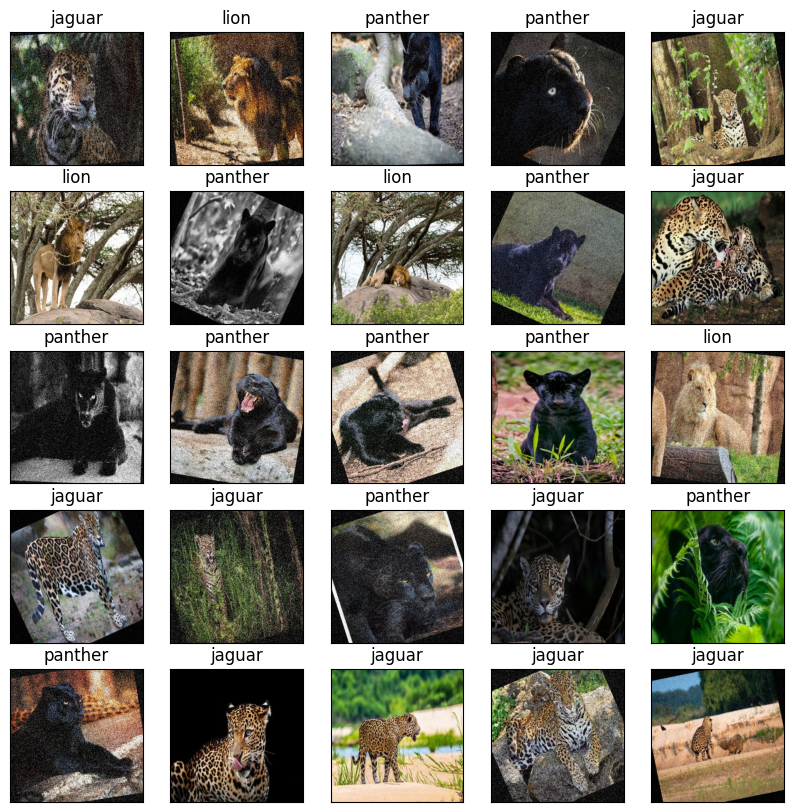

In [45]:
fig = plt.figure(figsize=(10, 10))
rows, columns = 5, 5
visualize_dataset = torchvision.datasets.ImageFolder(root=f'{BASE_DIR}/{path_train}')
# rand_indeces = np.random.randint(low=0, high=len(visualize_dataset), size=(rows*columns,))
rand_indeces = np.random.randint(low=0, high=len(train_dataset), size=(rows*columns,))
images = []
labels = []

for i in rand_indeces:
    img, class_ = visualize_dataset[i]
    images.append(img)
    labels.append(visualize_dataset.classes[class_])

# visualize these random images
for i in range(1, columns * rows + 1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(images[i-1])
    plt.xticks([])
    plt.yticks([])
    plt.title(f"{labels[i-1]}")

Задаем величину батча, число эпох, количество нейронов (классов) выходного слоя для обучения модели.
Величина батча принята равной 50, максимально допустимой из-за нехватки ОЗУ для выполнения эксперимента.

In [29]:
# Number of classes in the dataset
num_classes = len(train_dataset.classes)

# Batch size for training (change depending on how much memory you have)
batch_size = 50

# Number of epochs to train for
num_epochs = 15 #15

# Device for running training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [30]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    since = time.time()

    train_acc_history = []
    train_loss_history = []

    val_acc_history = []
    val_loss_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    y_pred_proba = torch.softmax(outputs, dim=1)
                    y_pred = y_pred_proba.argmax(dim=1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(y_pred == labels)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            # torch.save(model, f"e{epoch}_course_model_p{phase}_l{epoch_loss:.4f}_a{epoch_acc:.4f}.pth")

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
                val_loss_history.append(epoch_loss)
            if phase == 'train':
                train_acc_history.append(epoch_acc)
                train_loss_history.append(epoch_loss)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history, val_loss_history, train_acc_history, train_loss_history

In [46]:
# Create training and validation datasets

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# Create training and validation dataloaders
dataloaders_dict = {
    "train": train_dataloader,
    "val": test_dataloader,
}

## **Для сравнения с результатами transfer learning на предтренированной модели из первого задания выполним эксперимент на нетренированной модели ResNet18 типовой архитектуры на нашем наборе данных (jaguar, lion, panther). Для увеличения набора данных была выполнена аугментация данных с наложение шума и небольшой ротацией изображения с применением библиотеки imgaug** ##

In [35]:
class BasicBlock(nn.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        stride: int = 1,
        expansion: int = 1,
        downsample: nn.Module = None
    ) -> None:
        super(BasicBlock, self).__init__()
        # Multiplicative factor for the subsequent conv2d layer's output channels.
        # It is 1 for ResNet18 and ResNet34.
        self.expansion = expansion
        self.downsample = downsample
        self.conv1 = nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size=3,
            stride=stride,
            padding=1,
            bias=False
        )
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(
            out_channels,
            out_channels*self.expansion,
            kernel_size=3,
            padding=1,
            bias=False
        )
        self.bn2 = nn.BatchNorm2d(out_channels*self.expansion)
    def forward(self, x: torch.TensorType) -> torch.TensorType:
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample is not None:
            identity = self.downsample(x)
        out += identity
        out = self.relu(out)
        return  out

In [36]:
class ResNet(nn.Module):
    def __init__(
        self,
        img_channels: int,
        num_layers: int,
        block: type[BasicBlock],
        num_classes: int  = 1000
    ) -> None:
        super(ResNet, self).__init__()
        if num_layers == 18:
            # The following `layers` list defines the number of `BasicBlock`
            # to use to build the network and how many basic blocks to stack
            # together.
            layers = [2, 2, 2, 2]
            self.expansion = 1

        self.in_channels = 64
        # All ResNets (18 to 152) contain a Conv2d => BN => ReLU for the first
        # three layers. Here, kernel size is 7.
        self.conv1 = nn.Conv2d(
            in_channels=img_channels,
            out_channels=self.in_channels,
            kernel_size=7,
            stride=2,
            padding=3,
            bias=False
        )
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512*self.expansion, num_classes)
    def _make_layer(
        self,
        block: type[BasicBlock],
        out_channels: int,
        blocks: int,
        stride: int = 1
    ) -> nn.Sequential:
        downsample = None
        if stride != 1:
            """
            This should pass from `layer2` to `layer4` or
            when building ResNets50 and above. Section 3.3 of the paper
            Deep Residual Learning for Image Recognition
            (https://arxiv.org/pdf/1512.03385v1.pdf).
            """
            downsample = nn.Sequential(
                nn.Conv2d(
                    self.in_channels,
                    out_channels*self.expansion,
                    kernel_size=1,
                    stride=stride,
                    bias=False
                ),
                nn.BatchNorm2d(out_channels * self.expansion),
            )
        layers = []
        layers.append(
            block(
                self.in_channels, out_channels, stride, self.expansion, downsample
            )
        )
        self.in_channels = out_channels * self.expansion
        for i in range(1, blocks):
            layers.append(block(
                self.in_channels,
                out_channels,
                expansion=self.expansion
            ))
        return nn.Sequential(*layers)
    def forward(self, x: torch.TensorType) -> torch.TensorType:
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        # The spatial dimension of the final layer's feature
        # map should be (7, 7) for all ResNets.
        # print('Dimensions of the last convolutional feature map: ', x.shape)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

In [37]:
model = ResNet(img_channels=3, num_layers=18, block=BasicBlock, num_classes=num_classes)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Параметры модели

In [38]:
print(summary(model, input_size=(3, 224, 224)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [32]:

# Observe that all parameters are being optimized
# optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)
# optimizer_ft = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
optimizer_ft = optim.Adam(params=model.parameters())

In [39]:
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft, val_acc_history, val_loss_history, train_acc_history, train_loss_history = train_model(model, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs)

Epoch 0/14
----------
train Loss: 1.1597 Acc: 0.3313
val Loss: 1.1111 Acc: 0.4189

Epoch 1/14
----------
train Loss: 1.1589 Acc: 0.3327
val Loss: 1.1501 Acc: 0.3285

Epoch 2/14
----------


KeyboardInterrupt: 

#### **Результат эксперимента: точности не смогли привысить более 33%, т.к. датасет слишком мал для количества параметров=11,178,051 (train_dataset - 6300, test_dataset - 900), как видно из графиков accuracy и loss изменение значений незначительно, значит модель недотренирована и для обучения модели такого размера необходимо значительно больше данных.**
```text
Epoch 0/14
----------
train Loss: 1.1951 Acc: 0.3319
val Loss: 1.1542 Acc: 0.3322

Epoch 1/14
----------
train Loss: 1.1985 Acc: 0.3329
val Loss: 1.1871 Acc: 0.3322

Epoch 2/14
----------
train Loss: 1.1941 Acc: 0.3333
val Loss: 1.1871 Acc: 0.3322

Epoch 3/14
----------
train Loss: 1.1979 Acc: 0.3324
val Loss: 1.1864 Acc: 0.3322

Epoch 4/14
----------
train Loss: 1.1962 Acc: 0.3333
val Loss: 1.1875 Acc: 0.3322

Epoch 5/14
----------
train Loss: 1.1959 Acc: 0.3333
val Loss: 1.1872 Acc: 0.3322

Epoch 6/14
----------
train Loss: 1.1967 Acc: 0.3329
val Loss: 1.1848 Acc: 0.3322

Epoch 7/14
----------
train Loss: 1.1950 Acc: 0.3333
val Loss: 1.1876 Acc: 0.3322

Epoch 8/14
----------
train Loss: 1.1973 Acc: 0.3329
val Loss: 1.1856 Acc: 0.3322

Epoch 9/14
----------
train Loss: 1.1954 Acc: 0.3333
val Loss: 1.1863 Acc: 0.3322

Epoch 10/14
----------
train Loss: 1.1947 Acc: 0.3338
val Loss: 1.1871 Acc: 0.3322

Epoch 11/14
----------
train Loss: 1.1938 Acc: 0.3333
val Loss: 1.1871 Acc: 0.3322

Epoch 12/14
----------
train Loss: 1.1965 Acc: 0.3329
val Loss: 1.1866 Acc: 0.3322

Epoch 13/14
----------
train Loss: 1.1960 Acc: 0.3333
val Loss: 1.1882 Acc: 0.3322

Epoch 14/14
----------
train Loss: 1.1993 Acc: 0.3329
val Loss: 1.1884 Acc: 0.3322

Training complete in 93m 58s
Best val Acc: 0.332222
```
## Accuracy
![АСС](acc_0.33_batch_50_model_resnet18_custom.png)

## Loss function
![LOSS](loss_f_acc_0.33_batch_50_model_resnet18_custom.png)

In [50]:
val_acc_history_cpu = [i.item() for i in val_acc_history]
val_loss_history_cpu = val_loss_history
train_acc_history_cpu = [i.item() for i in train_acc_history]
train_loss_history_cpu = train_loss_history

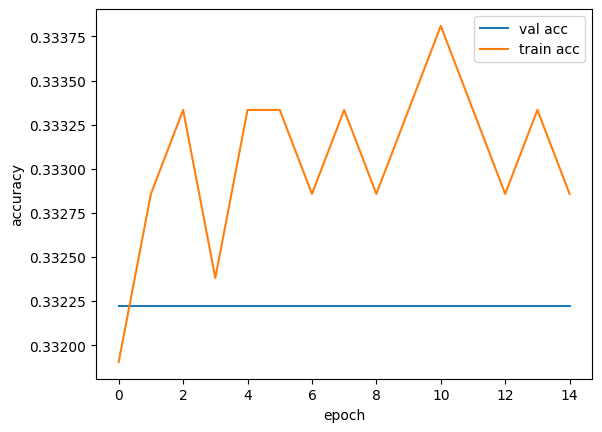

In [51]:
plt.plot(val_acc_history_cpu, label="val acc")
plt.plot(train_acc_history_cpu, label="train acc")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend()

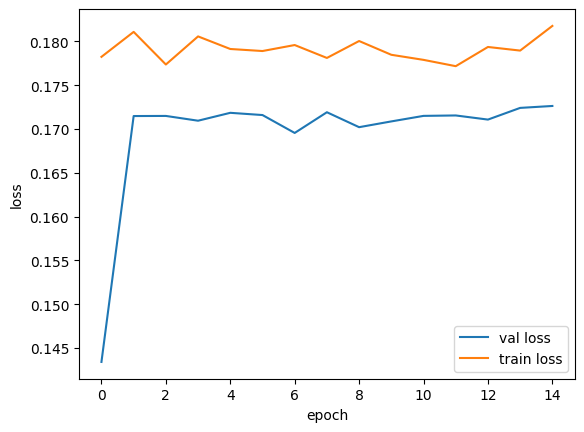

In [52]:
plt.plot(np.log(np.array(val_loss_history_cpu)), label="val loss")
plt.plot(np.log(np.array(train_loss_history_cpu)), label="train loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()

### **Для выполнения задания с тренировкой модели с простой собственной архитектурой было принято решение использовать модель из ДЗ 10 с небольшими корректировками: во входном слое установлено 3 нейрона, т.к. изображения трехканальные из нашего набора данных, также перерасичтаны параметры модели.**
### **Размер батча так же принят равным 50 из-за нехватки ОЗУ**

-----
- Эксперимент 1: train_dataset - 700 изображений в каждом классе, без аугментации данных, test_dataset - 300 в каждом классе, без аугментации данных, число эпох - 15
- Эксперимент 2: train_dataset - 2100 изображений в каждом классе, с аугментации данных, test_dataset - 900 в каждом классе, с аугментации данных, число эпох - 15
- Эксперимент 3: train_dataset - 2100 изображений в каждом классе, с аугментации данных, test_dataset - 300 в каждом классе, без аугментации данных, число эпох - 5

In [48]:

def time_counter(func):
    def wrapper(*args, **kwargs):
        ts = time()
        result = func(*args, **kwargs)
        te = time()
        delta = te - ts
        print(f'{func.__name__} выполнялся {strftime("%H:%M:%S", gmtime(delta))}')
        return result
    return wrapper


def print_metrics_scores(scores: dict) -> None:
    print(f'confusion_matrix: \n{scores.get("confusion_matrix")}')
    print(f'classification_report: \n{scores.get("classification_report")}')


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 50, 3, 1)             # 3*3*3*50+50 = 1400
        self.conv2 = nn.Conv2d(50, 20, 3, 1)            # 3*3*50*20+20 = 9020
        self.conv3 = nn.Conv2d(20, 8, 3, 1)            # 3*3*20*8+8 = 1448
        self.dropout1 = nn.Dropout(0.25)                # <- 0
        self.dropout2 = nn.Dropout(0.5)                 # <- 0
        self.fc1 = nn.Linear(23328, 128)                  # <- 23328*128+128 = 2986112
        self.fc2 = nn.Linear(128, 3)                   # <- 128*3+3 = 387
        self.batch_norm = torch.nn.BatchNorm1d(23328)     # <- 23328*2 = 46656
                                                        # Total: 3045023
    def forward(self, x):           # 50, 3, 224, 224
        x = self.conv1(x)           # 50, 50, 222, 222
        x = F.relu(x)               # 50, 50, 222, 222
        x = self.conv2(x)           # 50, 20, 220, 220
        x = F.relu(x)               # 50, 20, 220, 220
        x = F.max_pool2d(x, 2)      # 50, 20, 110, 110
        x = self.conv3(x)           # 50, 8, 108, 108
        x = F.relu(x)               # 50, 8, 108, 108
        x = F.max_pool2d(x, 2)      # 50, 8, 54, 54
        x = self.dropout1(x)        # 50, 8, 54, 54
        x = torch.flatten(x, 1)     # 50, 8*54*54 = 23328
        x = self.batch_norm(x)      # 50, 23328
        x = self.fc1(x)             # 50, 128
        x = F.relu(x)               # 50, 128
        x = self.dropout2(x)        # 50, 128
        output = self.fc2(x)        # 50, 3
        return output


def model_train(model, device, train_loader, optimizer, epoch, loss_fn):
    train_loss = 0
    correct = 0
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, target)
        train_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        loss.backward()
        optimizer.step()
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch + 1, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    train_loss /= len(train_loader.dataset)
    train_loss_list.append(train_loss)
    train_accuracy = correct / len(train_loader.dataset)
    train_accuracy_list.append(train_accuracy)


def model_test(model, device, test_loader, loss_fn):
    model.eval()
    test_loss = 0
    correct = 0
    all_target = []
    all_pred = []
    classification_metrics_dict = {}
    with torch.no_grad():
        for batch_idx_, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)
            output = model(data)
            # sum up batch loss
            test_loss += loss_fn(output, target).item()
            # get the index of the max log-probability
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            all_target = [*all_target, *target.tolist()]
            all_pred = [*all_pred, *pred.tolist()]
            if batch_idx_ == len(test_loader) - 1:
                target_names = ['cls 0', 'cls 1', 'cls 2']
                all_target = torch.Tensor(all_target)
                all_pred = torch.Tensor(all_pred)
                classification_metrics_dict.update({
                    'confusion_matrix': confusion_matrix(all_target, all_pred),
                    'classification_report': classification_report(all_target, all_pred, target_names=target_names)
                })
                print_metrics_scores(classification_metrics_dict)
                disp = ConfusionMatrixDisplay(
                    confusion_matrix=classification_metrics_dict['confusion_matrix'],
                    display_labels=target_names
                )
                disp.plot()
                plt.savefig(f"Confusion_matrix.png")
                plt.close()

    test_loss /= len(test_loader.dataset)
    test_loss_list.append(test_loss)
    test_accuracy = correct / len(test_loader.dataset)
    test_accuracy_list.append(test_accuracy)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * test_accuracy))


@time_counter
def main():

    torch.manual_seed(1337)

    device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
    print(device)

    batch_size_ds = 50

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size_ds, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size_ds, shuffle=False)

    epochs = 5 # 15

    model = Net().to(device)
    optimizer = optim.Adadelta(model.parameters(), lr=0.1)
    loss_fn = torch.nn.CrossEntropyLoss()

    scheduler = StepLR(optimizer, step_size=1, gamma=0.5)
    for epoch in range(epochs):
        model_train(model, device, train_loader, optimizer, epoch, loss_fn)
        model_test(model, device, test_loader, loss_fn)
        scheduler.step()

    torch.save(model.state_dict(), "mnist_cnn.pt")
    print(f"# Params: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")
    print(model)
    print(summary(model, input_size=(3, 224, 224)))


def plot_curve(title_: str, xlabel_: str, ylabel_: str,
               curve_list_1: list, curve_list_2: list, curve_label_1: str,
               curve_label_2: str, file_name: str) -> None:
    fig, ax = plt.subplots(figsize=(8, 8))
    plt.title(f'{title_}')
    plt.xlabel(f'{xlabel_}')
    plt.ylabel(f'{ylabel_}')
    ax.plot(np.arange(0, len(curve_list_1), 1), curve_list_1, "o-", label=curve_label_1)
    ax.plot(np.arange(0, len(curve_list_2), 1), curve_list_2, "o-", label=curve_label_2)
    ax.legend(loc="best")

    plt.savefig(f"{file_name}")
    plt.close()


if __name__ == '__main__':
    # Init lists
    train_loss_list = []
    test_loss_list = []
    train_accuracy_list = []
    test_accuracy_list = []

    main()

    # Plot results
    plot_curve('Loss function', 'Samples', 'Loss',
               train_loss_list, test_loss_list,
               "Train loss", "Test loss", "Loss.png")
    plot_curve('Loss function', 'Samples', 'Loss',
               train_loss_list, test_loss_list,
               "Log train loss", "Log test loss", "Loss_log.png")
    plot_curve('Accuracy curve', 'Epoch', 'Accuracy',
               train_accuracy_list, test_accuracy_list,
               "Train", "Test", "Accuracy curve.png")


cpu
Train Epoch: 1 [0/6300 (0%)]	Loss: 1.130582
Train Epoch: 1 [500/6300 (8%)]	Loss: 0.476960
Train Epoch: 1 [1000/6300 (16%)]	Loss: 0.476063
Train Epoch: 1 [1500/6300 (24%)]	Loss: 0.384168
Train Epoch: 1 [2000/6300 (32%)]	Loss: 0.277627
Train Epoch: 1 [2500/6300 (40%)]	Loss: 0.345626
Train Epoch: 1 [3000/6300 (48%)]	Loss: 0.314325
Train Epoch: 1 [3500/6300 (56%)]	Loss: 0.391605
Train Epoch: 1 [4000/6300 (63%)]	Loss: 0.260880
Train Epoch: 1 [4500/6300 (71%)]	Loss: 0.373712
Train Epoch: 1 [5000/6300 (79%)]	Loss: 0.318774
Train Epoch: 1 [5500/6300 (87%)]	Loss: 0.261423
Train Epoch: 1 [6000/6300 (95%)]	Loss: 0.453117
confusion_matrix: 
[[226  64  10]
 [ 11 280   9]
 [  5  25 270]]
classification_report: 
              precision    recall  f1-score   support

       cls 0       0.93      0.75      0.83       300
       cls 1       0.76      0.93      0.84       300
       cls 2       0.93      0.90      0.92       300

    accuracy                           0.86       900
   macro avg     

#### **Параметры модели**
```
# Params: 3045023
Net(
  (conv1): Conv2d(3, 50, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(50, 20, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(20, 8, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=23328, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=3, bias=True)
  (batch_norm): BatchNorm1d(23328, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
================================================================
            Conv2d-1         [-1, 50, 222, 222]           1,400
            Conv2d-2         [-1, 20, 220, 220]           9,020
            Conv2d-3          [-1, 8, 108, 108]           1,448
           Dropout-4            [-1, 8, 54, 54]               0
       BatchNorm1d-5                [-1, 23328]          46,656
            Linear-6                  [-1, 128]       2,986,112
           Dropout-7                  [-1, 128]               0
            Linear-8                    [-1, 3]             387
================================================================
Total params: 3,045,023
Trainable params: 3,045,023
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 27.26
Params size (MB): 11.62
Estimated Total Size (MB): 39.45
----------------------------------------------------------------
None
```

### **Эксперимент 1.**
**Как видно из графиков значение точности модели не привысило 91%, из чего можно сделать вывод что модель не дотренирована и датасет необходимо увеличить**
**Результаты:**
```text
Train Epoch: 15 [0/2100 (0%)]	Loss: 0.185801
Train Epoch: 15 [500/2100 (24%)]	Loss: 0.095153
Train Epoch: 15 [1000/2100 (48%)]	Loss: 0.156850
Train Epoch: 15 [1500/2100 (71%)]	Loss: 0.137849
Train Epoch: 15 [2000/2100 (95%)]	Loss: 0.223287
confusion_matrix:
[[273  23   4]
 [ 24 265  11]
 [  5  17 278]]
classification_report:
              precision    recall  f1-score   support

       cls 0       0.90      0.91      0.91       300
       cls 1       0.87      0.88      0.88       300
       cls 2       0.95      0.93      0.94       300

    accuracy                           0.91       900
   macro avg       0.91      0.91      0.91       900
weighted avg       0.91      0.91      0.91       900


Test set: Average loss: 0.0057, Accuracy: 816/900 (91%)

Время выполнения: 01:02:05
```

#### Accuracy
![АСС](Accuracy_curve_custom_1.png)

#### Loss function
![LOSS](Loss_log_custom_1.png)

#### Loss function
![C_M](Confusion_matrix_custom_1.png)

### **Эксперимент 2.**
**Как видно из графиков значение точности модели достигло 95%, из чего можно сделать вывод, что обучение модели на дополненом датасете аугментированными изображениями проходит более качественно. Показатель точности 95% на аугментированных данных достиг на 7 эпохе, в эксперименте 3 будет применен тестовый датасет без аугментированных данных, я сравнения результатов.**
**Результаты:**
```text
cpu
Train Epoch: 15 [0/6300 (0%)]	Loss: 0.162337
Train Epoch: 15 [500/6300 (8%)]	Loss: 0.323298
Train Epoch: 15 [1000/6300 (16%)]	Loss: 0.214716
Train Epoch: 15 [1500/6300 (24%)]	Loss: 0.194537
Train Epoch: 15 [2000/6300 (32%)]	Loss: 0.055068
Train Epoch: 15 [2500/6300 (40%)]	Loss: 0.152138
Train Epoch: 15 [3000/6300 (48%)]	Loss: 0.150175
Train Epoch: 15 [3500/6300 (56%)]	Loss: 0.058304
Train Epoch: 15 [4000/6300 (63%)]	Loss: 0.187624
Train Epoch: 15 [4500/6300 (71%)]	Loss: 0.142884
Train Epoch: 15 [5000/6300 (79%)]	Loss: 0.143068
Train Epoch: 15 [5500/6300 (87%)]	Loss: 0.110166
Train Epoch: 15 [6000/6300 (95%)]	Loss: 0.154724
confusion_matrix:
[[832  51  17]
 [  8 871  21]
 [ 19  28 853]]
classification_report:
              precision    recall  f1-score   support

       cls 0       0.97      0.92      0.95       900
       cls 1       0.92      0.97      0.94       900
       cls 2       0.96      0.95      0.95       900

    accuracy                           0.95      2700
   macro avg       0.95      0.95      0.95      2700
weighted avg       0.95      0.95      0.95      2700


Test set: Average loss: 0.0039, Accuracy: 2556/2700 (95%)

Время выполнения: 03:38:06
```

#### Accuracy
![АСС](Accuracy_curve_custom_2.png)

#### Loss function
![LOSS](Loss_log_custom_2.png)

#### Loss function
![C_M](Confusion_matrix_custom_2.png)

### **Эксперимент 3.**
**Как видно из графиков значение точности модели достигло 95% на 5 эпохе, из чего можно сделать вывод, что применение тестового датасета без аугментированных данных дает показатель точности выше с меньшим количество эпох. Также можно сделать вывод, что аугментированные данные в тестовом датасете не позволяют корректно определить, когда был достигнут оверфит и в какой момент нужно было остановить обучение.**
**Результаты:**
```text
cpu

Train Epoch: 5 [0/6300 (0%)]	Loss: 0.369282
Train Epoch: 5 [500/6300 (8%)]	Loss: 0.064681
Train Epoch: 5 [1000/6300 (16%)]	Loss: 0.131391
Train Epoch: 5 [1500/6300 (24%)]	Loss: 0.061574
Train Epoch: 5 [2000/6300 (32%)]	Loss: 0.222997
Train Epoch: 5 [2500/6300 (40%)]	Loss: 0.140125
Train Epoch: 5 [3000/6300 (48%)]	Loss: 0.130098
Train Epoch: 5 [3500/6300 (56%)]	Loss: 0.067750
Train Epoch: 5 [4000/6300 (63%)]	Loss: 0.169977
Train Epoch: 5 [4500/6300 (71%)]	Loss: 0.365631
Train Epoch: 5 [5000/6300 (79%)]	Loss: 0.277765
Train Epoch: 5 [5500/6300 (87%)]	Loss: 0.266641
Train Epoch: 5 [6000/6300 (95%)]	Loss: 0.187090
confusion_matrix:
[[283  15   2]
 [  7 289   4]
 [  5   8 287]]
classification_report:
              precision    recall  f1-score   support

       cls 0       0.96      0.94      0.95       300
       cls 1       0.93      0.96      0.94       300
       cls 2       0.98      0.96      0.97       300

    accuracy                           0.95       900
   macro avg       0.96      0.95      0.95       900
weighted avg       0.96      0.95      0.95       900


Test set: Average loss: 0.0033, Accuracy: 859/900 (95%)

Время выполнения: 01:09:42
```

#### Accuracy
![АСС](Accuracy_curve_custom_3.png)

#### Loss function
![LOSS](Loss_log_custom_3.png)

#### Loss function
![C_M](Confusion_matrix_custom_3.png)